# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

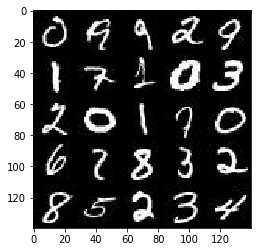

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

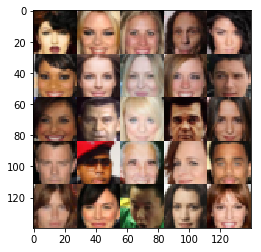

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x128
    
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_rate2 = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
      
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate2, beta1)
    

    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
          
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))


                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate2: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate2: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    
                    _ = show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 19.7007... Generator Loss: 0.0227
Epoch 1/2... Discriminator Loss: 18.8206... Generator Loss: 57.3087
Epoch 1/2... Discriminator Loss: 15.7142... Generator Loss: 0.0285
Epoch 1/2... Discriminator Loss: 2.1249... Generator Loss: 10.9262
Epoch 1/2... Discriminator Loss: 13.7944... Generator Loss: 0.0807
Epoch 1/2... Discriminator Loss: 4.4499... Generator Loss: 5.3164
Epoch 1/2... Discriminator Loss: 2.3174... Generator Loss: 1.6183
Epoch 1/2... Discriminator Loss: 3.6881... Generator Loss: 10.0412
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 2.1168
Epoch 1/2... Discriminator Loss: 2.1718... Generator Loss: 0.7263


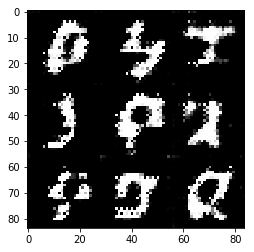

Epoch 1/2... Discriminator Loss: 2.1444... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 5.8450... Generator Loss: 0.0103
Epoch 1/2... Discriminator Loss: 2.0061... Generator Loss: 1.5928
Epoch 1/2... Discriminator Loss: 5.2879... Generator Loss: 5.8982
Epoch 1/2... Discriminator Loss: 3.6044... Generator Loss: 0.0845
Epoch 1/2... Discriminator Loss: 2.1092... Generator Loss: 0.5587
Epoch 1/2... Discriminator Loss: 2.3409... Generator Loss: 5.4499
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 1.9423
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.6205


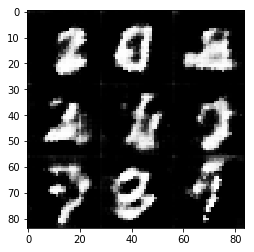

Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 1.5733
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 1.9487
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 2.2087
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.8607... Generator Loss: 3.0104
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.6061
Epoch 1/2... Discriminator Loss: 2.1314... Generator Loss: 2.6680


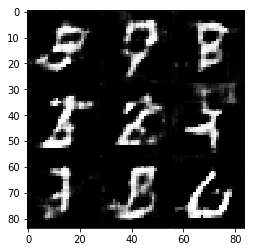

Epoch 1/2... Discriminator Loss: 1.8203... Generator Loss: 0.2574
Epoch 1/2... Discriminator Loss: 1.7629... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.5884... Generator Loss: 2.5034
Epoch 1/2... Discriminator Loss: 1.7713... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.6907... Generator Loss: 1.9672
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 1.4040
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 2.3059
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.4934
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.4863


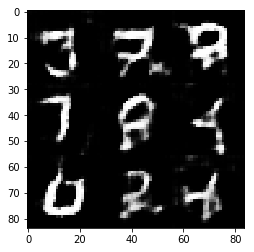

Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.4585
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 1.9425... Generator Loss: 2.7014
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 1.5045
Epoch 1/2... Discriminator Loss: 2.0859... Generator Loss: 2.5050
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 1.2433
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.4374


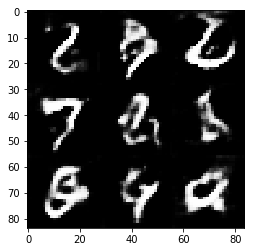

Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 1.3732
Epoch 1/2... Discriminator Loss: 1.6718... Generator Loss: 0.3463
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 1.7368... Generator Loss: 0.2950
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.4291
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 1.2683


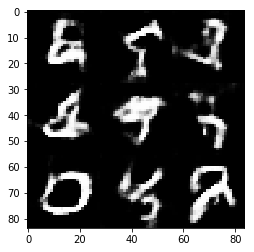

Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 1.6651
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 1.4730
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 2.0130... Generator Loss: 0.2092
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.6623
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 1.1385


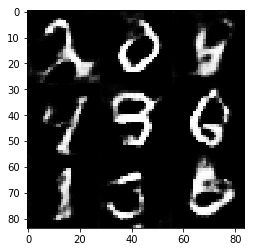

Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.8138... Generator Loss: 0.2816
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.3882
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.8481


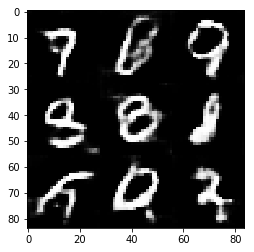

Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.5316
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.8860
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 1.9216
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.7825... Generator Loss: 0.3054
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.1595
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 1.0515... Generator Loss: 1.5844
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 1.1183


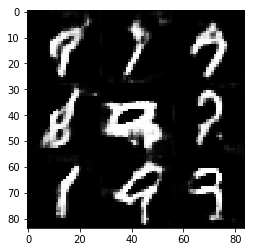

Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 1.9132
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 1.5735
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 1.5473
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.4558
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 1.8183
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.5550


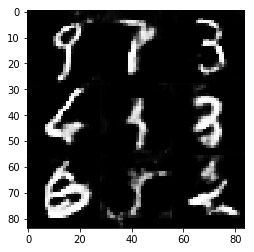

Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 1.6654... Generator Loss: 0.3587
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 1.6948... Generator Loss: 0.2990
Epoch 2/2... Discriminator Loss: 1.6375... Generator Loss: 0.3606
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.9224... Generator Loss: 3.3813
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 1.4800


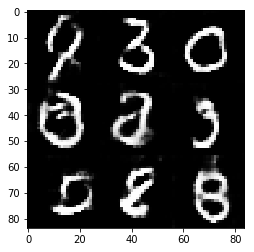

Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.5149
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 1.2592
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.8531... Generator Loss: 0.2492
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 1.7725
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 1.7473... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.4852


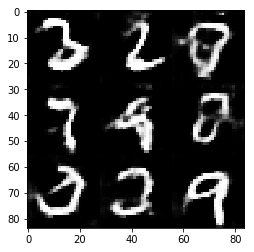

Epoch 2/2... Discriminator Loss: 1.7230... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.4901
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.9821
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.4574
Epoch 2/2... Discriminator Loss: 1.6293... Generator Loss: 2.4557
Epoch 2/2... Discriminator Loss: 1.5358... Generator Loss: 0.4121
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 0.8406


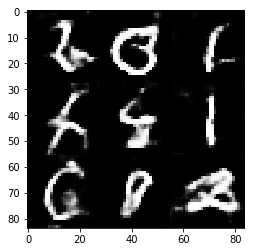

Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 1.2047
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.7297... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.1636
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 2.3315
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 1.0052
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.9293


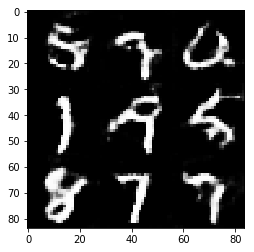

Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 1.1428
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.6288
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.8556


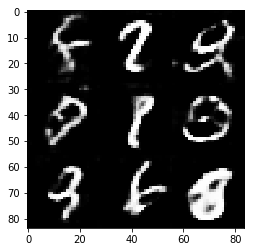

Epoch 2/2... Discriminator Loss: 2.8177... Generator Loss: 3.4509
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.5463
Epoch 2/2... Discriminator Loss: 0.8916... Generator Loss: 1.1197
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 1.2664
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.5434


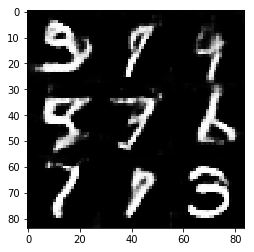

Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 1.5589... Generator Loss: 3.2256
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.5275
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.5094
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.4441
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 1.8994
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 1.0716


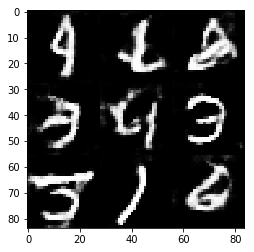

Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 1.6286... Generator Loss: 2.6305
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 1.5998
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.4882
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.5390
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 1.0185


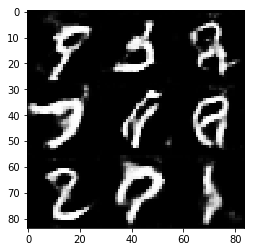

Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 1.7741
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 1.0354... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 1.7721... Generator Loss: 0.2794


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6558... Generator Loss: 8.5339
Epoch 1/1... Discriminator Loss: 10.3621... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 4.0380
Epoch 1/1... Discriminator Loss: 2.2198... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 5.9347... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 3.2281... Generator Loss: 2.1967
Epoch 1/1... Discriminator Loss: 9.2429... Generator Loss: 0.0023
Epoch 1/1... Discriminator Loss: 0.2739... Generator Loss: 4.9739
Epoch 1/1... Discriminator Loss: 2.0543... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 2.9460... Generator Loss: 9.0479


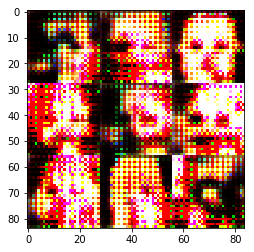

Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 3.6876
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 3.8214
Epoch 1/1... Discriminator Loss: 2.5378... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 2.6125... Generator Loss: 5.0580
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 2.5336
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 7.3075
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 7.5929
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 5.5251
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 9.0937
Epoch 1/1... Discriminator Loss: 2.7639... Generator Loss: 0.7826


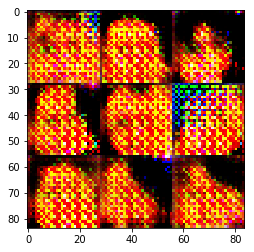

Epoch 1/1... Discriminator Loss: 2.9226... Generator Loss: 11.6724
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 3.9216
Epoch 1/1... Discriminator Loss: 7.5213... Generator Loss: 0.0064
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 2.1194
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 1.7486
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 7.1270
Epoch 1/1... Discriminator Loss: 1.6928... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.0155
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 1.6437


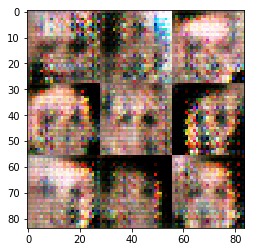

Epoch 1/1... Discriminator Loss: 5.8024... Generator Loss: 3.8985
Epoch 1/1... Discriminator Loss: 1.9753... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 2.0018
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 1.9168... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.9727... Generator Loss: 0.2426
Epoch 1/1... Discriminator Loss: 1.8383... Generator Loss: 0.3017
Epoch 1/1... Discriminator Loss: 2.9139... Generator Loss: 4.6815
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.4558


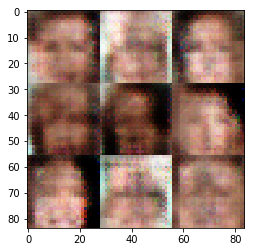

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 2.6388
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 1.9079
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.7974


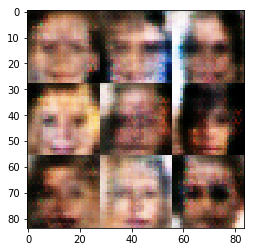

Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 2.2320
Epoch 1/1... Discriminator Loss: 1.7658... Generator Loss: 3.0788
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 2.5135... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 3.3503


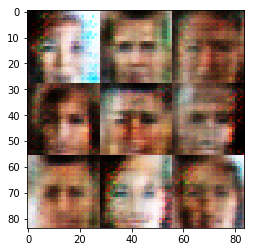

Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 2.6419
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 2.0599


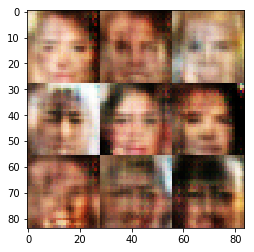

Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.7121... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.4194


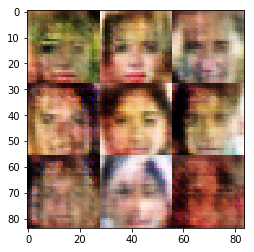

Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.7231
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 2.7014
Epoch 1/1... Discriminator Loss: 1.8008... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.9198... Generator Loss: 2.5246


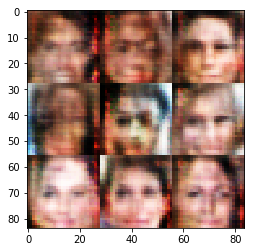

Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 0.3085... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 1.8694
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8113


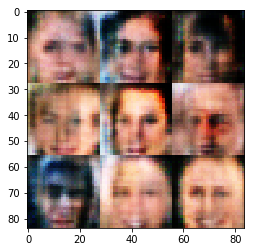

Epoch 1/1... Discriminator Loss: 1.9877... Generator Loss: 0.2469
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5125


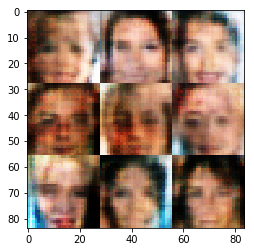

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6205


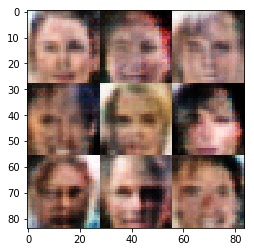

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5087


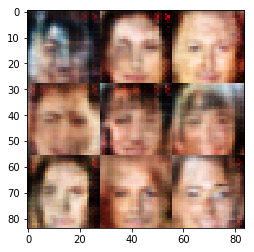

Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.3515


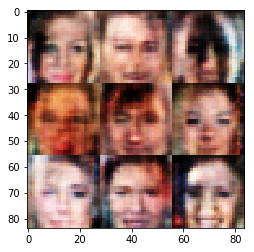

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.9550


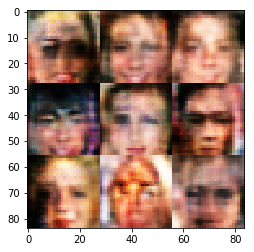

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.4505


In [17]:
batch_size =128
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.